<a href="https://colab.research.google.com/github/ataSeyfi/comp4902/blob/main/Unet/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import math
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import cv2

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, PReLU,  LeakyReLU, Flatten, Input, Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,Adadelta, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive'
%cd '/content/drive/My Drive'

Mounted at /content/drive
 20220327_173301.jpg					    model_m15.3.4.keras
 app.py							    model_m15.3.keras
 checkpoint						    model_m15.keras
'Colab Notebooks'					    model_m16.keras
 dataset						    model_m17.keras
 digitalTransformation.gslides				    model_m18.keras
 index.html						    model_m19.keras
 model_1new.h5						    model_m1.keras
 model_1pickle.pkl					    model_m1test.keras
 model_deployment_test1.h5				    model_m20.keras
 model_deployment_test1.keras				    model_m2.2.keras
 model_deployment_test1_weights.data-00000-of-00001	    model_m2.3.keras
 model_deployment_test1_weights.h5			    model_m2.keras
 model_deployment_test1_weights.index			    model_m2YEDEK.keras
 model_deployment_test1_weights.keras			    model_m3.3.keras
 model_deployment_test1_weights_keras.data-00000-of-00001   model_m3.keras
 model_deployment_test1_weights_keras.index		    model_m3Yedek.keras
 model_m10.3.keras					    model_m4.keras
 model_m10.keras					    model_m5.2.keras
 model_m11.1.1

In [3]:

train_dir = '/content/drive/My Drive/dataset/Infection Segmentation Data/Infection Segmentation Data/Train/'
test_dir = '/content/drive/My Drive/dataset/Infection Segmentation Data/Infection Segmentation Data/Test/'
val_dir = '/content/drive/My Drive/dataset/Infection Segmentation Data/Infection Segmentation Data/Val/'



In [4]:


def create_dataframe_from_directory(data_dir):
    filenames, image_paths, mask_paths, labels = [], [], [], []

    for folder_name in os.listdir(data_dir):
        image_folder_path = os.path.join(data_dir, folder_name, 'images')
        mask_folder_path = os.path.join(data_dir, folder_name, 'infection masks')  # update the folder name

        image_list = sorted([filename for filename in os.listdir(image_folder_path)])
        mask_list = sorted([filename for filename in os.listdir(mask_folder_path)])

        for image_filename, mask_filename in zip(image_list, mask_list):
            image_list_path = os.path.join(folder_name, 'images', image_filename)
            mask_list_path = os.path.join(folder_name, 'infection masks', mask_filename)

            filenames.append(image_list_path)
            image_paths.append(os.path.join(image_folder_path, image_filename))
            mask_paths.append(os.path.join(mask_folder_path, mask_filename))
            labels.append(folder_name)

    return pd.DataFrame({
        'filename': filenames,
        'image_path': image_paths,
        'mask_path': mask_paths,
        'label': labels
    })

# Example usage:
train_df = create_dataframe_from_directory(train_dir)
val_df = create_dataframe_from_directory(val_dir)
test_df = create_dataframe_from_directory(test_dir)


In [5]:
train_df

,filename,image_path,mask_path,label
0,COVID-19/images/covid_1.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
1,COVID-19/images/covid_100.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
2,COVID-19/images/covid_1000.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
3,COVID-19/images/covid_1001.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
4,COVID-19/images/covid_1002.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
...,...,...,...,...
3723,Normal/images/Normal (2104).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
3724,Normal/images/Normal (2105).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
3725,Normal/images/Normal (2106).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
3726,Normal/images/Normal (2107).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal


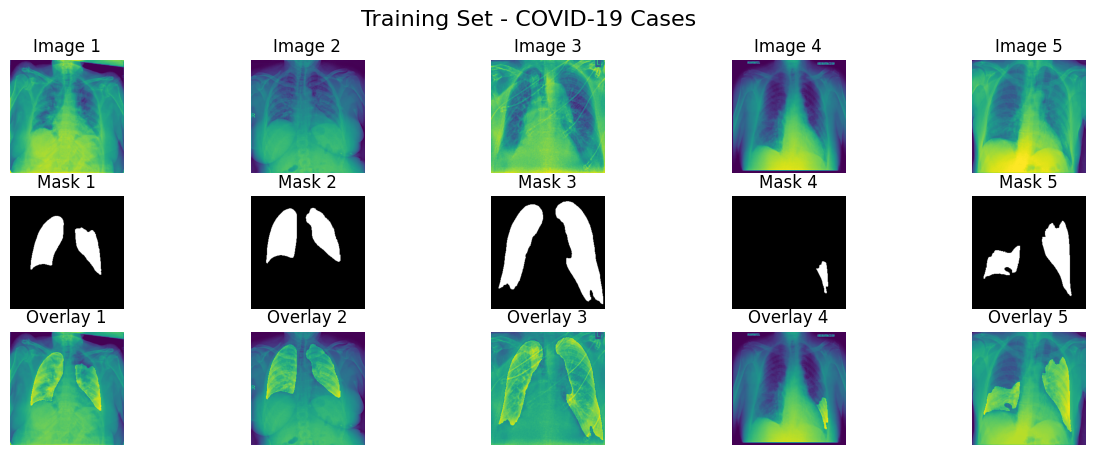

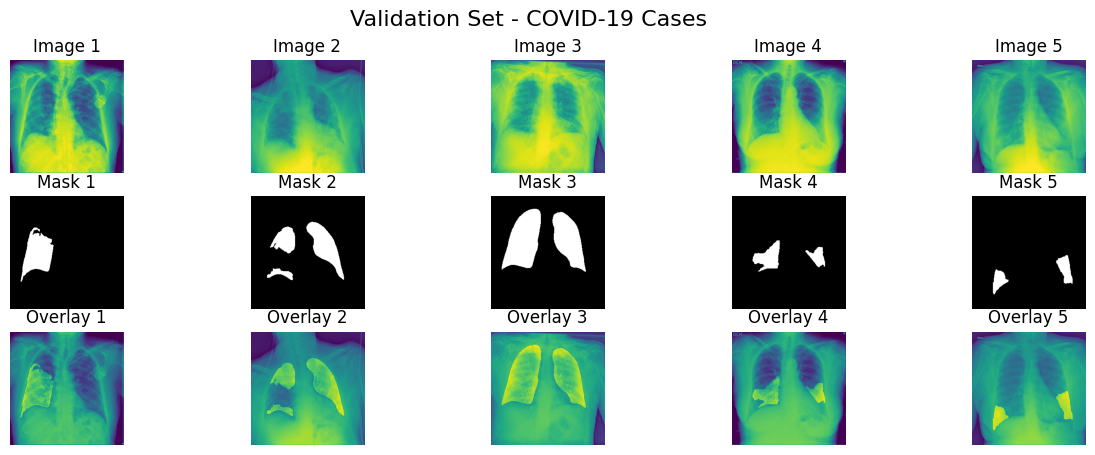

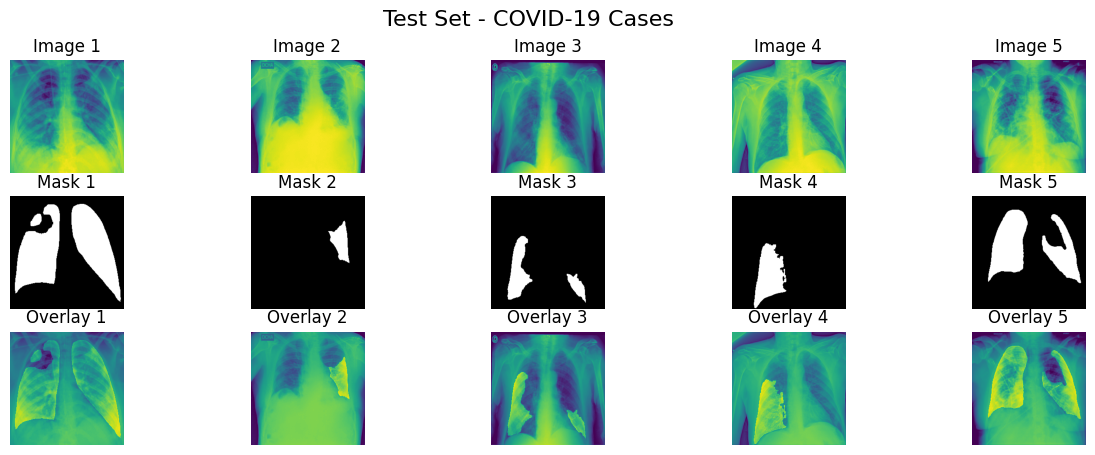

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images_with_masks(df, title):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    for i in range(5):
        plt.subplot(3, 5, i + 1)
        img_path = df['image_path'].iloc[i]
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(f"Image {i + 1}")
        plt.axis('off')

        plt.subplot(3, 5, i + 6)
        mask_path = df['mask_path'].iloc[i]
        mask = mpimg.imread(mask_path)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask {i + 1}")
        plt.axis('off')

        plt.subplot(3, 5, i + 11)
        overlay = cv2.addWeighted(img, 0.8, mask, 0.3, 0)
        plt.imshow(overlay)
        plt.title(f"Overlay {i + 1}")
        plt.axis('off')

    plt.show()

# Plotting COVID-19 cases from the training set
plot_images_with_masks(train_df[train_df['label'] == 'COVID-19'], title='Training Set - COVID-19 Cases')

# Plotting COVID-19 cases from the validation set
plot_images_with_masks(val_df[val_df['label'] == 'COVID-19'], title='Validation Set - COVID-19 Cases')

# Plotting COVID-19 cases from the test set
plot_images_with_masks(test_df[test_df['label'] == 'COVID-19'], title='Test Set - COVID-19 Cases')


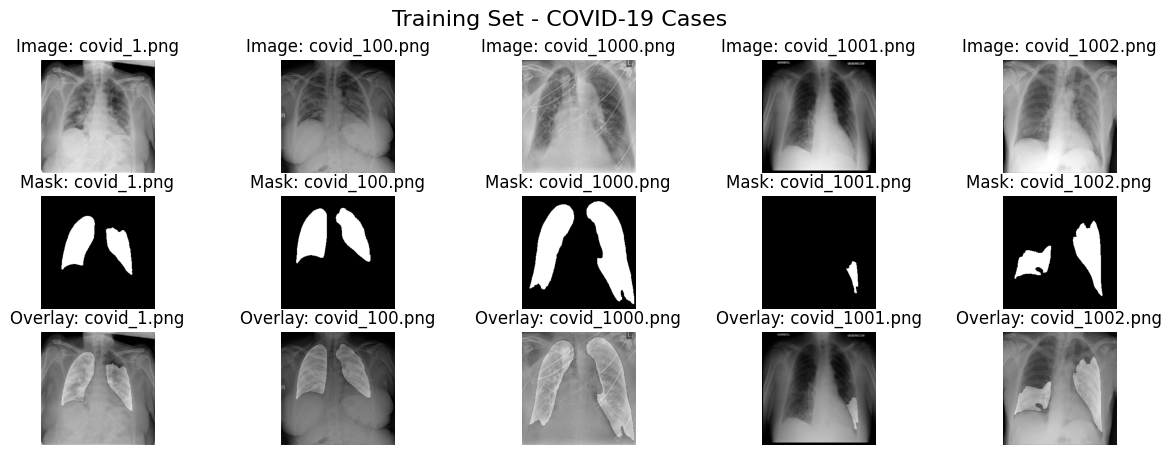

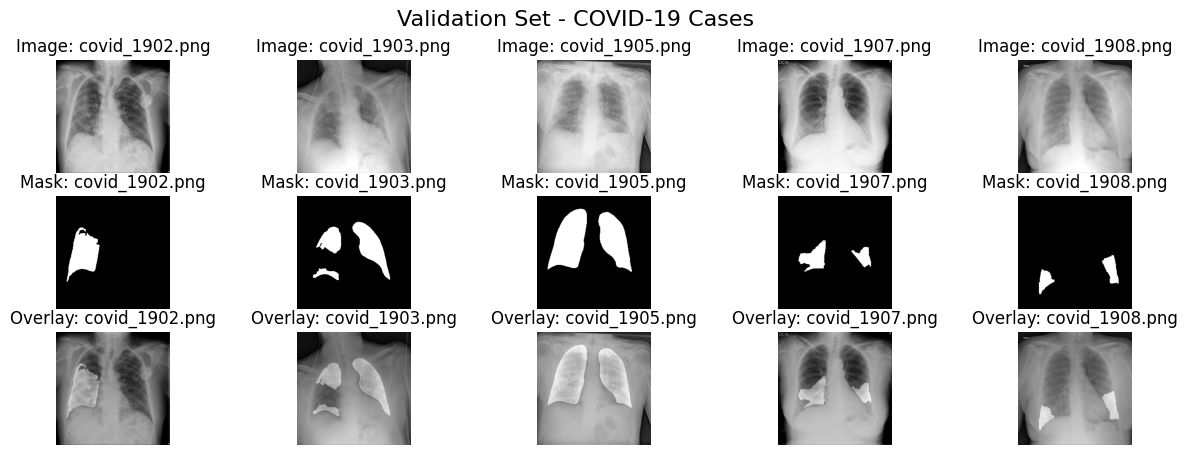

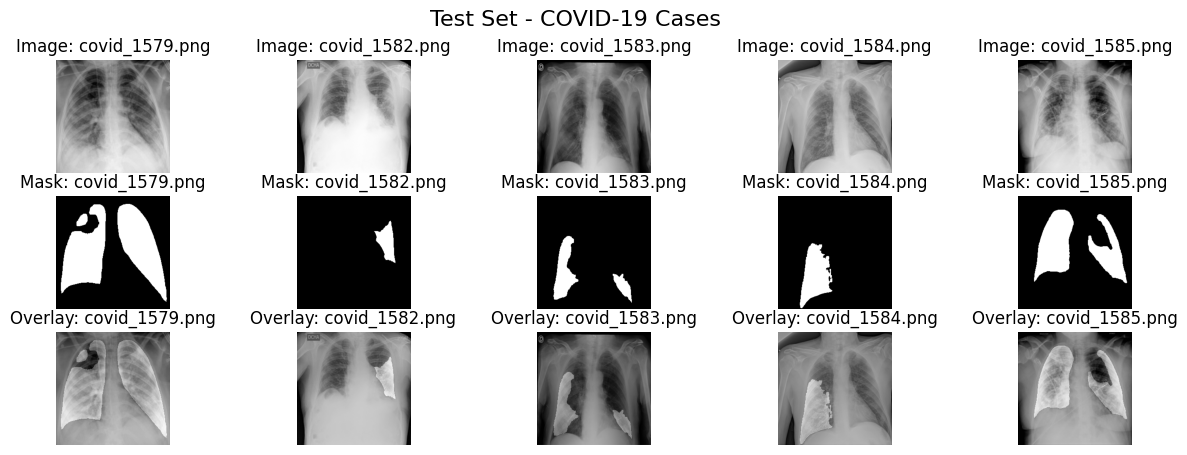

In [7]:
import cv2
import matplotlib.pyplot as plt

def plot_images_with_masks_cv2(df, title):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    for i in range(5):
        plt.subplot(3, 5, i + 1)
        img_path = df['image_path'].iloc[i]
        img_name = img_path.split("/")[-1]  # Extract the image name from the path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR, convert to RGB
        plt.imshow(img)
        plt.title(f"Image: {img_name}")
        plt.axis('off')

        plt.subplot(3, 5, i + 6)
        mask_path = df['mask_path'].iloc[i]
        mask_name = mask_path.split("/")[-1]  # Extract the mask name from the path
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask: {mask_name}")
        plt.axis('off')

        plt.subplot(3, 5, i + 11)
        overlay = cv2.addWeighted(img, 0.8, cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB), 0.3, 0)
        plt.imshow(overlay)
        plt.title(f"Overlay: {img_name}")
        plt.axis('off')

    plt.show()

# Plotting COVID-19 cases from the training set
plot_images_with_masks_cv2(train_df[train_df['label'] == 'COVID-19'], title='Training Set - COVID-19 Cases')

# Plotting COVID-19 cases from the validation set
plot_images_with_masks_cv2(val_df[val_df['label'] == 'COVID-19'], title='Validation Set - COVID-19 Cases')

# Plotting COVID-19 cases from the test set
plot_images_with_masks_cv2(test_df[test_df['label'] == 'COVID-19'], title='Test Set - COVID-19 Cases')


In [8]:


def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0  # Normalize pixel values to the range [0, 1]
    return img

def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    mask = mask / 255.0  # Normalize pixel values to the range [0, 1]
    return mask



In [9]:
train_df

,filename,image_path,mask_path,label
0,COVID-19/images/covid_1.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
1,COVID-19/images/covid_100.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
2,COVID-19/images/covid_1000.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
3,COVID-19/images/covid_1001.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
4,COVID-19/images/covid_1002.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19
...,...,...,...,...
3723,Normal/images/Normal (2104).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
3724,Normal/images/Normal (2105).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
3725,Normal/images/Normal (2106).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal
3726,Normal/images/Normal (2107).png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,Normal


In [10]:
import concurrent.futures

def preprocess_dataframe(df):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        df['image'] = list(executor.map(preprocess_image, df['image_path']))
        df['mask'] = list(executor.map(preprocess_mask, df['mask_path']))

# Preprocess the dataframes using parallel processing
preprocess_dataframe(train_df)
preprocess_dataframe(val_df)
preprocess_dataframe(test_df)

In [11]:
# Explicitly shutdown the ThreadPoolExecutor
concurrent.futures.thread._threads_queues.clear()

In [12]:
train_df.head()

,filename,image_path,mask_path,label,image,mask
0,COVID-19/images/covid_1.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.4627450980392157, 0.4627450980392157, 0.4...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,COVID-19/images/covid_100.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.0392156862745098, 0.0392156862745098, 0.0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,COVID-19/images/covid_1000.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.10588235294117647, 0.10588235294117647, 0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,COVID-19/images/covid_1001.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,COVID-19/images/covid_1002.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.023529411764705882, 0.023529411764705882,...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [13]:
val_df.head()

,filename,image_path,mask_path,label,image,mask
0,COVID-19/images/covid_1902.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,COVID-19/images/covid_1903.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.06274509803921569, 0.06274509803921569, 0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,COVID-19/images/covid_1905.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.25098039215686274, 0.25098039215686274, 0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,COVID-19/images/covid_1907.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.18823529411764706, 0.18823529411764706, 0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,COVID-19/images/covid_1908.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.10588235294117647, 0.10588235294117647, 0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [14]:
test_df.head()

,filename,image_path,mask_path,label,image,mask
0,COVID-19/images/covid_1579.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.403921568627451, 0.403921568627451, 0.403...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,COVID-19/images/covid_1582.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.0784313725490196, 0.0784313725490196, 0.0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,COVID-19/images/covid_1583.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.07450980392156863, 0.07450980392156863, 0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,COVID-19/images/covid_1584.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.6784313725490196, 0.6784313725490196, 0.6...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,COVID-19/images/covid_1585.png,/content/drive/My Drive/dataset/Infection Segm...,/content/drive/My Drive/dataset/Infection Segm...,COVID-19,"[[[0.00392156862745098, 0.00392156862745098, 0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [15]:




def create_unet(input_shape=(256, 256, 3), num_classes=1):
    # Define the VGG19 model without top layer
    vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    # Encoder
    encoder = vgg19_base.get_layer('block5_conv4').output  # Use the output of the last convolutional layer in block5

    # Decoder
    decoder = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', activation='relu')(encoder)
    decoder = concatenate([vgg19_base.get_layer('block4_conv4').output, decoder], axis=-1)
    decoder = Conv2D(512, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2D(512, (3, 3), activation='relu', padding='same')(decoder)

    decoder = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', activation='relu')(decoder)
    decoder = concatenate([vgg19_base.get_layer('block3_conv4').output, decoder], axis=-1)
    decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(decoder)

    decoder = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', activation='relu')(decoder)
    decoder = concatenate([vgg19_base.get_layer('block2_conv2').output, decoder], axis=-1)
    decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder)

    decoder = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(decoder)
    decoder = concatenate([vgg19_base.get_layer('block1_conv2').output, decoder], axis=-1)
    decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)

    decoder = Conv2D(num_classes, (1, 1), activation='sigmoid')(decoder)

    # Create the U-Net model
    unet_model = Model(inputs=vgg19_base.input, outputs=decoder)

    return unet_model



In [16]:

# Create the U-Net model
MODEL_UNET = create_unet()

# Display the model summary
MODEL_UNET.summary()

80134624/80134624 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                             

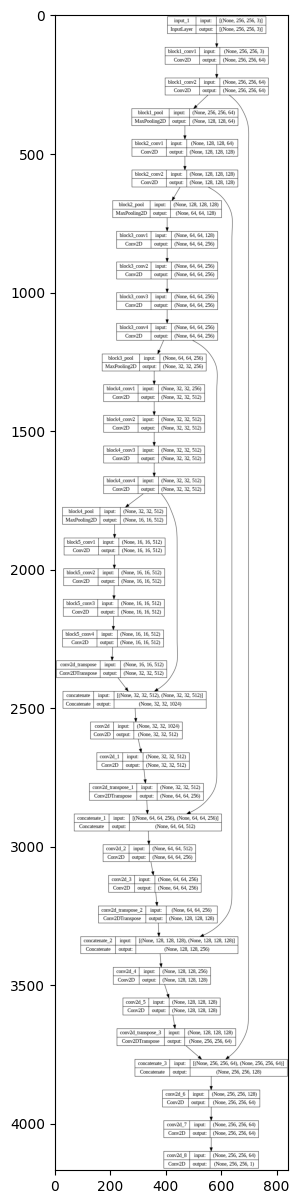

In [17]:
from keras.utils import plot_model
import matplotlib.pyplot as plt


plot_model(MODEL_UNET, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

# Display the model architecture image
img = plt.imread('unet_model.png')
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show()


In [ ]:
#unet_model.png

In [18]:
def load_images_and_masks(df):
    images = []
    masks = []

    for index, row in df.iterrows():

        image = row['image']
        mask = row['mask']

        images.append(image)
        masks.append(mask)

    # Convert lists to numpy arrays
    images = np.array(images)
    masks = np.array(masks)

    return images, masks


In [19]:

# Load images and masks for training data
x_train, y_train = load_images_and_masks(train_df)

# Load images and masks for validation data
x_val, y_val = load_images_and_masks(val_df)

# Load images and masks for test data
x_test, y_test = load_images_and_masks(test_df)

In [20]:
y_train.shape

(3728, 256, 256, 1)

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999)
MODEL_UNET.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('unet_model.h5', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6, verbose=1)



# Train the model
history = MODEL_UNET.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=4,
    epochs=40,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)



Epoch 1/40
932/932 [==============================] - ETA: 0s - loss: 0.1808 - accuracy: 0.9337
Epoch 1: val_loss improved from inf to 0.15724, saving model to unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


932/932 [==============================] - 95s 89ms/step - loss: 0.1808 - accuracy: 0.9337 - val_loss: 0.1572 - val_accuracy: 0.9307 - lr: 1.0000e-04
Epoch 2/40
932/932 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.9486
Epoch 2: val_loss improved from 0.15724 to 0.09350, saving model to unet_model.h5
932/932 [==============================] - 77s 83ms/step - loss: 0.1202 - accuracy: 0.9486 - val_loss: 0.0935 - val_accuracy: 0.9591 - lr: 1.0000e-04
Epoch 3/40
932/932 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.9583
Epoch 3: val_loss did not improve from 0.09350
932/932 [==============================] - 74s 79ms/step - loss: 0.0970 - accuracy: 0.9583 - val_loss: 0.0949 - val_accuracy: 0.9589 - lr: 1.0000e-04
Epoch 4/40
932/932 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9619
Epoch 4: val_loss improved from 0.09350 to 0.07593, saving model to unet_model.h5
932/932 [==============================] - 77s 83ms

In [ ]:
# Evaluate the model on the test set

test_loss, test_accuracy = MODEL_UNET.evaluate(x_test, y_test, batch_size=4)

# Make predictions on the test set
predictions = MODEL_UNET.predict(x_test)

# Perform thresholding to classify COVID-19 positive and negative cases
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)


In [ ]:
predictions

In [ ]:
binary_predictions[:5]

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


In [21]:
#load model

In [22]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('unet_model.h5')

In [23]:
# Assuming you have x_test and y_test ready
test_loss, test_accuracy = loaded_model.evaluate(x_test, y_test, batch_size=4)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


292/292 [==============================] - 17s 26ms/step - loss: 0.0640 - accuracy: 0.9758
Test Loss: 0.0640
Test Accuracy: 0.9758


In [24]:
# Assuming x_test is your test set
predictions = loaded_model.predict(x_test)


# Perform thresholding to classify COVID-19 positive and negative cases
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)


37/37 [==============================] - 10s 172ms/step
